#### Antes de ler esse notebook recomendo fortemente a leitura do arquivo README, disponível na pasta deste projeto no github.

In [1]:
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from datetime import datetime
import plotly.express as px

Os dados disponibilidados pela empresa estão em arquivos diferentes, separados por mês. O código comentado abaixo concatena (junta) os dados dos arquivos de cada mês e cria um único arquivo com todos os dados. Nesse caso específico será mais facil trabalhar com um arquivo único, já que o pacote Pandas consegue lidar tranquilamente com esse volume de dados (aproximandamente 1 gigabyte de dados)

In [2]:
#Utilizei esse código para fazer a concatenação. Ele pode ser encontrado em:
# https://github.com/ekapope/Combine-CSV-files-in-the-folder/blob/master/Combine_CSVs.py

#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#print(all_filenames)

#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [3]:
full_df = pd.read_csv('C:/Users/Victor/Desktop/Estudos_Data/GoogleProjetoFinal/datasets/combined_csv.csv')

Com o dataset carregado podemos começar a fazer a análise exploratória e entender quais dados temos disponíveis, como estão organizados, quais problemas nós temos, etc.

In [4]:
full_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0A1B623926EF4E16,docked_bike,2021-07-02 14:44:36,2021-07-02 15:19:58,Michigan Ave & Washington St,13001,Halsted St & North Branch St,KA1504000117,41.883984,-87.624684,41.899368,-87.648480,casual
1,B2D5583A5A5E76EE,classic_bike,2021-07-07 16:57:42,2021-07-07 17:16:09,California Ave & Cortez St,17660,Wood St & Hubbard St,13432,41.900363,-87.696704,41.889899,-87.671473,casual
2,6F264597DDBF427A,classic_bike,2021-07-25 11:30:55,2021-07-25 11:48:45,Wabash Ave & 16th St,SL-012,Rush St & Hubbard St,KA1503000044,41.860384,-87.625813,41.890173,-87.626185,member
3,379B58EAB20E8AA5,classic_bike,2021-07-08 22:08:30,2021-07-08 22:23:32,California Ave & Cortez St,17660,Carpenter St & Huron St,13196,41.900363,-87.696704,41.894556,-87.653449,member
4,6615C1E4EB08E8FB,electric_bike,2021-07-28 16:08:06,2021-07-28 16:27:09,California Ave & Cortez St,17660,Elizabeth (May) St & Fulton St,13197,41.900350,-87.696682,41.886593,-87.658387,casual


In [5]:
full_df.info(show_counts = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900385 entries, 0 to 5900384
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             5900385 non-null  object 
 1   rideable_type       5900385 non-null  object 
 2   started_at          5900385 non-null  object 
 3   ended_at            5900385 non-null  object 
 4   start_station_name  5064367 non-null  object 
 5   start_station_id    5064370 non-null  object 
 6   end_station_name    5008282 non-null  object 
 7   end_station_id      5008282 non-null  object 
 8   start_lat           5900385 non-null  float64
 9   start_lng           5900385 non-null  float64
 10  end_lat             5895011 non-null  float64
 11  end_lng             5895011 non-null  float64
 12  member_casual       5900385 non-null  object 
dtypes: float64(4), object(9)
memory usage: 585.2+ MB


In [6]:
full_df.isnull().any(axis=1).sum()

1221514

Aqui temos as informações básicas da tabela, como o número de colunas (13), o tipo de dado em cada coluna e a contagem de dados não nulos. Logo algo chama a minha atenção: dentre os quase 6 milhões de registros, temos quatro colunas que apresentam aproximadamente 900 mil valores ausentes cada. Vamos tentar entender porque esses valores estão ausentes.

## valores ausentes

Vamos analisar melhor as colunas com dados ausentes:

In [7]:
full_df[full_df['start_station_id'].isna()].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1180,25C3D7AFB7E7F741,electric_bike,2021-07-07 10:17:26,2021-07-07 10:45:30,NaN,NaN,Clark St & Schreiber Ave,KA1504000156,41.96,-87.69,41.999221,-87.671354,member
1614,D9085C8F15E1E7DD,electric_bike,2021-07-18 17:45:04,2021-07-18 19:31:28,NaN,NaN,Lake Shore Dr & Monroe St,13300,41.89,-87.63,41.880955,-87.616731,casual
1616,3EB56093160EE720,electric_bike,2021-07-24 16:23:31,2021-07-24 16:31:54,NaN,NaN,Southport Ave & Clybourn Ave,TA1309000030,41.91,-87.64,41.920755,-87.663708,member
1617,0CC59B329E349370,electric_bike,2021-07-01 11:53:56,2021-07-01 13:18:52,NaN,NaN,Southport Ave & Clybourn Ave,TA1309000030,41.92,-87.67,41.920690,-87.663757,member
1620,21D6EC4B51C56226,electric_bike,2021-07-04 16:12:43,2021-07-04 17:03:03,NaN,NaN,Lakefront Trail & Bryn Mawr Ave,KA1504000152,41.90,-87.69,41.984036,-87.652265,casual


In [8]:
columns_with_na = ['start_station_name','start_station_id','end_station_name','end_station_id', 'start_lat', 'start_lng',
                   'end_lat','end_lng']
full_df[full_df['start_station_id'].isna()][columns_with_na].sample(5, random_state=1)

,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng
2871741,NaN,NaN,NaN,NaN,41.79,-87.59,41.790000,-87.600000
2381004,NaN,NaN,NaN,NaN,41.76,-87.62,41.760000,-87.610000
3588768,NaN,NaN,NaN,NaN,41.94,-87.74,41.940000,-87.750000
940009,NaN,NaN,NaN,NaN,41.92,-87.70,41.920000,-87.700000
2572241,NaN,NaN,University Ave & 57th St,KA1503000071,41.78,-87.59,41.791438,-87.600021


Aqui começa a ficar mais claro a razão de termos valores ausentes. Por algum motivo perdemos dados precisos acerca da geolocalização de cada bicicleta. Como vemos acima, não temos o nome nem o ID da estação de início quando "start_lat" e "start_lng" possuem apenas 2 casas decimais. Isso acontece porque duas casas decimais representam os minutos de uma coordenada geográfica. Como cada minuto possui 1,8 km de distância, fica impossível determinar a estação que uma determinada bicicleta saiu, já que as distâncias entre as estações de bicicleta próximas umas das outras são bem menores do que 1,8 km. Apenas para comprovar nossa hipótese, vamos ver se as estações de chegada apresentam o mesmo problema.

In [9]:
full_df[full_df['end_station_id'].isna()][columns_with_na].sample(5, random_state=1)

,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng
4094187,NaN,NaN,NaN,NaN,41.810000,-87.7200,41.81,-87.71
4415842,NaN,NaN,NaN,NaN,41.930000,-87.7100,41.96,-87.71
599727,NaN,NaN,NaN,NaN,41.950000,-87.7100,41.93,-87.69
1482075,NaN,NaN,NaN,NaN,41.920000,-87.7300,41.91,-87.72
558469,Wood St & Hubbard St,13432,NaN,NaN,41.889904,-87.6716,41.94,-87.70


Precisamente o mesmo problema! Note que mesmo que em algumas linhas tenhamos 6 casas decimais nas colunas "start_lat" e "start_lng", as quatro últimas são zero, ou seja, não apresentam informação.

A forma que vamos lidar com os valores ausentes dependem de diversos fatores, e em um projeto real seria válido consultar as partes interessadas (stakeholders/área de negócios). Como nesse caso não há uma área de negócios e eu sou o único analista nesse projeto, terei que tomar uma decisão por conta própria.

Nesse caso específico a minha decisão será manter as linhas que possuem algum dado ausente, pois elas ainda podem conter informações relevantes em outras colunas. Ainda assim, ficaremos atentos para o fato de que aproximadamente 1/5 de todos os nossos registros possuem pelo menos um valor ausente.

#### Vamos continuar com a análise exploratória de dados

In [10]:
full_df.member_casual.value_counts()

member    3342158
casual    2558227
Name: member_casual, dtype: int64

<AxesSubplot: xlabel='rideable_type,member_casual'>

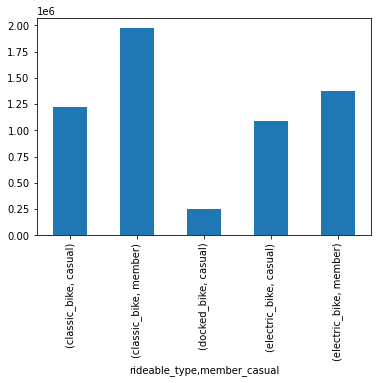

In [11]:
full_df.groupby(['rideable_type', 'member_casual']).size().plot(kind='bar')

### Tipagem de dados: Trabalhando com a classe Datetime

In [12]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900385 entries, 0 to 5900384
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 585.2+ MB


Podemos notar que a data e a hora de cada viagem está no formato de texto (string). Para que possamos fazer análises utilizando essas informações, precisamos transformá-las para um formato mais prático. O formato datetime é ideal para manipularmos dados de tempo.

In [13]:
full_df['started_at'] = pd.to_datetime(full_df['started_at'], format="%Y-%m-%d %H:%M:%S")
full_df['ended_at'] = pd.to_datetime(full_df['ended_at'], format="%Y-%m-%d %H:%M:%S")

In [14]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900385 entries, 0 to 5900384
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 585.2+ MB


Há informações valiosas demais dentro das colunas de tempo. Vamos criar colunas contendo as frações de informações presentes na coluna "started_at"

In [15]:
full_df['day_of_the_week'] = full_df['started_at'].dt.day_name()
full_df['month_name'] = full_df['started_at'].dt.month_name()
full_df['full_date'] = full_df['started_at'].dt.date
full_df['hour_start'] = full_df['started_at'].dt.hour
full_df['travel_time_in_min'] = full_df['ended_at'] - full_df['started_at']
full_df['minute_start'] = full_df['started_at'].dt.minute
full_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_the_week,month_name,full_date,hour_start,travel_time_in_min,minute_start
0,0A1B623926EF4E16,docked_bike,2021-07-02 14:44:36,2021-07-02 15:19:58,Michigan Ave & Washington St,13001,Halsted St & North Branch St,KA1504000117,41.883984,-87.624684,41.899368,-87.648480,casual,Friday,July,2021-07-02,14,0 days 00:35:22,44
1,B2D5583A5A5E76EE,classic_bike,2021-07-07 16:57:42,2021-07-07 17:16:09,California Ave & Cortez St,17660,Wood St & Hubbard St,13432,41.900363,-87.696704,41.889899,-87.671473,casual,Wednesday,July,2021-07-07,16,0 days 00:18:27,57
2,6F264597DDBF427A,classic_bike,2021-07-25 11:30:55,2021-07-25 11:48:45,Wabash Ave & 16th St,SL-012,Rush St & Hubbard St,KA1503000044,41.860384,-87.625813,41.890173,-87.626185,member,Sunday,July,2021-07-25,11,0 days 00:17:50,30
3,379B58EAB20E8AA5,classic_bike,2021-07-08 22:08:30,2021-07-08 22:23:32,California Ave & Cortez St,17660,Carpenter St & Huron St,13196,41.900363,-87.696704,41.894556,-87.653449,member,Thursday,July,2021-07-08,22,0 days 00:15:02,8
4,6615C1E4EB08E8FB,electric_bike,2021-07-28 16:08:06,2021-07-28 16:27:09,California Ave & Cortez St,17660,Elizabeth (May) St & Fulton St,13197,41.900350,-87.696682,41.886593,-87.658387,casual,Wednesday,July,2021-07-28,16,0 days 00:19:03,8


In [16]:
full_df['travel_time_in_min'].describe()

count                      5900385
mean     0 days 00:20:16.942832713
std      0 days 02:35:13.345907040
min              -1 days +21:42:35
25%                0 days 00:06:17
50%                0 days 00:11:10
75%                0 days 00:20:12
max               34 days 02:27:09
Name: travel_time_in_min, dtype: object

In [17]:
full_df[full_df.travel_time_in_min < pd.Timedelta('0 days 00:00:00')].index

Int64Index([  72118,   72309,   72856,  133756,  206601,  206749,  207167,
             207973,  216418,  447155,
            ...
            5409986, 5432458, 5664064, 5699971, 5707632, 5716473, 5716849,
            5716853, 5737562, 5813679],
           dtype='int64', length=146)

In [18]:
full_df[full_df.travel_time_in_min > pd.Timedelta('1 days 0:00:00')].index

Int64Index([   2615,    3885,    6965,    8035,    8328,    8419,    8626,
               8730,    9055,    9075,
            ...
            5886611, 5886643, 5886645, 5886656, 5886702, 5886786, 5886788,
            5886806, 5886959, 5887145],
           dtype='int64', length=4718)

Podemos notar um problema. A viagem com o menor tempo nos nossos dados é uma viagem com tempo negativo, ou seja, ela terminou antes de começar. Como isso é impossível, fica claro que é um erro dos dados. Ao explorar esse erro, vi que são apenas 148 linhas com esse problema. Vamos eliminá-las.

Também não me parece razoável que uma única viagem dure mais do que 24 horas, já que niguém consegue pedalar por todo esse tempo sem descansar. Na verdade, eu poderia escolher o número máximo de horas de uma viagem que deixaria na minha análise, e embora eu ainda ache 24 horas um tempo bastante grande, não quero excluir muitas linhas que possam ter outras informações interessantes. São 4718 linhas que possuem um tempo de viagem maior do que 24 horas. Também vamos eliminá-las:

In [19]:
full_df = full_df.drop(full_df[full_df.travel_time_in_min < pd.Timedelta('0 days 00:00:00')].index)
full_df = full_df.drop(full_df[full_df.travel_time_in_min > pd.Timedelta('1 days 0:00:00')].index)
full_df = full_df.reset_index(drop=True)

Agora que já fizemos alguns tratamentos essenciais nos nossos dados, podemos começar a fazer uma análise gráfica. O primeiro gráfico que vou criar é a relação do número de viagens entre Casuals e Members em cada dia da semana.

Com esse resumo estatístico podemos observar uma diferença interessante: as viagens feitas pelos Casuals em média duram mais do que as viagens feitas pelos Members. Uma hipótese, que será explorada mais adiante, é que os Members utilizam mais as bicicletas para ir e voltar do trabalho em viagens curtas, enquanto os Casuals as utilizam com maior frequência para atividades de lazer, com viagens mais longas.

In [20]:
groupedbyday = full_df.groupby(['day_of_the_week', 'member_casual'], as_index = False).size()
groupedbyday = groupedbyday.pivot("day_of_the_week", "member_casual", "size")
groupedbyday = groupedbyday.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
groupedbyday

C:\Users\Victor\AppData\Local\Temp\ipykernel_9528\2391407112.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  groupedbyday = groupedbyday.pivot("day_of_the_week", "member_casual", "size")


member_casual,casual,member
day_of_the_week,,
Monday,303479,468952
Tuesday,277344,518157
Wednesday,285064,516485
Thursday,324635,525839
Friday,362537,469179
Saturday,534740,444068
Sunday,466211,398831


<AxesSubplot: xlabel='day_of_the_week'>

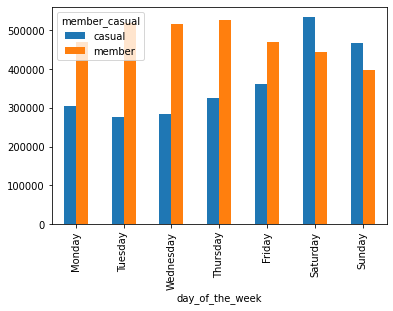

In [21]:
groupedbyday.plot(kind='bar')

No gráfico acima já encontramos uma diferença de comportamento bastante grande entre os nossos dois tipos de clientes. Durante os dias úteis, o número de viagens feitas por Members supera muito o número de viagens feitas por Casuals, tendência essa que se inverte aos finais de semana. Uma hipótese é que muitos dos nossos clientes que assinam o plano anual utilizam as bicicletas para ir ao trabalho, enquanto os Casuals as utilizam mais por lazer (aos finais de semana). Ainda assim, é notável que os members as utilizam bastante mesmo durante o fim de semana.

Esse primeiro gráfico foi criado de maneira bastante simples, servindo apenas para que o analista pudesse fazer uma análise gráfica de maneira rápida. Como esse gráfico contem uma informação valiosa, vamos personalizá-lo utilizando uma biblioteca própria para a criação de gráficos, a biblioteca Matplotlib

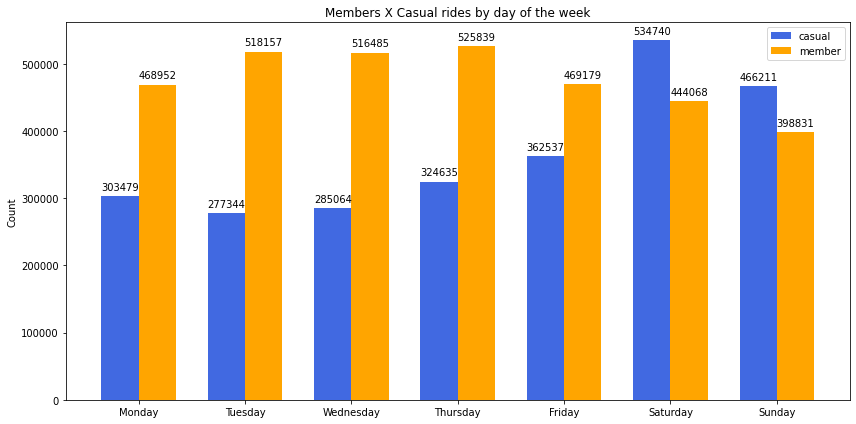

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
width=0.35
lenweek = np.arange(len([1,2,3,4,5,6,7]))
barscasual = ax.bar(lenweek - width/2, groupedbyday.casual, 0.35, label='casual', color='royalblue')
barsmember = ax.bar(lenweek + width/2, groupedbyday.member, 0.35, label='member', color='orange')

ax.bar_label(barscasual, padding=4)
ax.bar_label(barsmember, padding=4)

ax.set_ylabel('Count')
ax.set_title('Members X Casual rides by day of the week')
ax.set_xticks(lenweek, labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday', ])
ax.legend()

fig.tight_layout()

plt.show()

Agora o gráfico está muito mais profissional e agradável de se ver. Poderiamos perfeitamente mostrar esse gráfico em uma reunião de negócios. Vamos continuar analisando os dados, agora por pela hora do dia em que a viagem começou.

In [23]:
groupedbyhour = full_df.groupby(['hour_start', 'member_casual'], as_index = False).size()
#groupedbyhour = groupedbyhour.pivot("hour_start", "member_casual", "size")

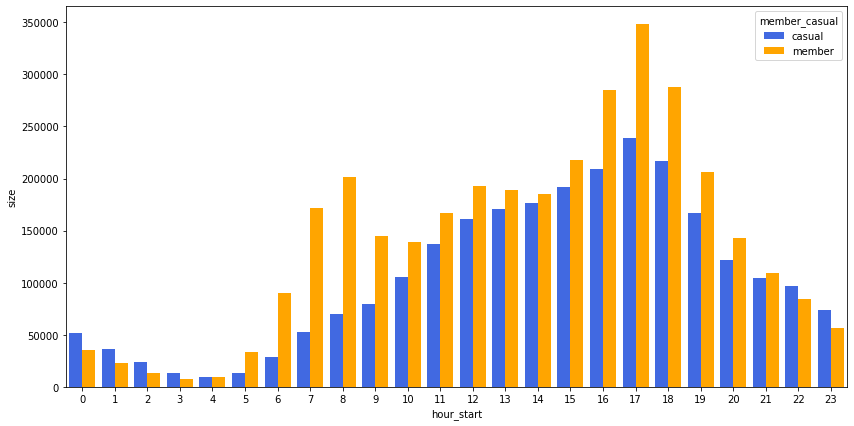

In [24]:
plt.figure(figsize=(14,7))
sns.barplot(data=groupedbyhour, x="hour_start", y='size', hue="member_casual", palette=['royalblue', 'orange'], saturation=1)
plt.show()

Podemos aumentar o nível de granularidade e observar o mesmo gráfico separado pelos minutos de cada hora. Apenas para fins ilustrativos, vamos criá-lo.

C:\Users\Victor\AppData\Local\Temp\ipykernel_9528\3319454507.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  groupedbyminuteandhour = groupedbyminuteandhour.pivot(["hour_start", 'minute_start'], "member_casual", "size")


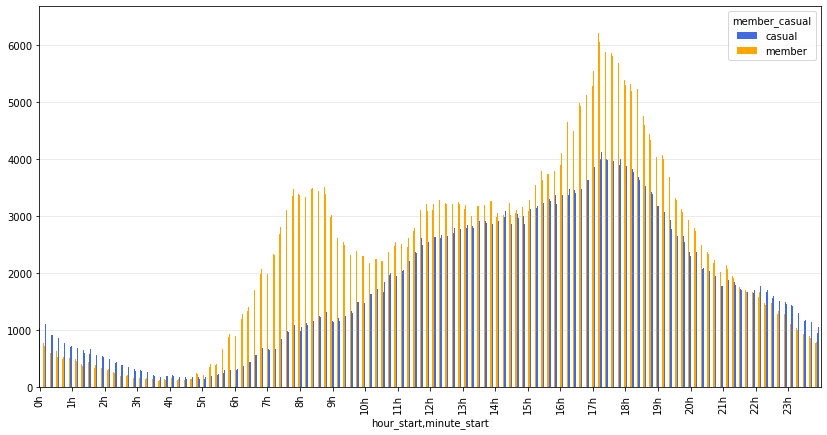

In [25]:
groupedbyminuteandhour = full_df.groupby(['minute_start', 'hour_start', 'member_casual',], as_index = False).size()
groupedbyminuteandhour = groupedbyminuteandhour.pivot(["hour_start", 'minute_start'], "member_casual", "size")
groupedbyminuteandhour.plot.bar(figsize=(14,7), color=['royalblue', 'orange'])
plt.xticks(ticks= range(0,1440,60), labels = [str(range(0,24)[i]) + "h" for i in range(0,24)])
plt.grid(axis='y', alpha = 0.3)
plt.show()

Essas visualizações são bastante ilustrativas. Podemos notar que há dois períodos durante o dia em que a diferença do número de viagens entre Members e Casuals cresce significativamente: primeiro entre 6 e 8 da manhã, e depois entre 16 e 18 horas. A hipótese de que nossos Members utilizam muito o nosso serviço para ir ao trabalho/escola (commute, em inglês) está cada vez mais fundamentada nos dados. Porém, ainda não estamos satisfeitos. Vamos comparar especificamente um dia útil (Terça-feira) e o Sábado. Se nossa hipótese estiver correta a supremacia dos Members nessas janelas de horários deve ser ainda maior na terça. Todavia, é provável que os números se invertam no Sábado, quando a maioria das pessoas não trabalham.

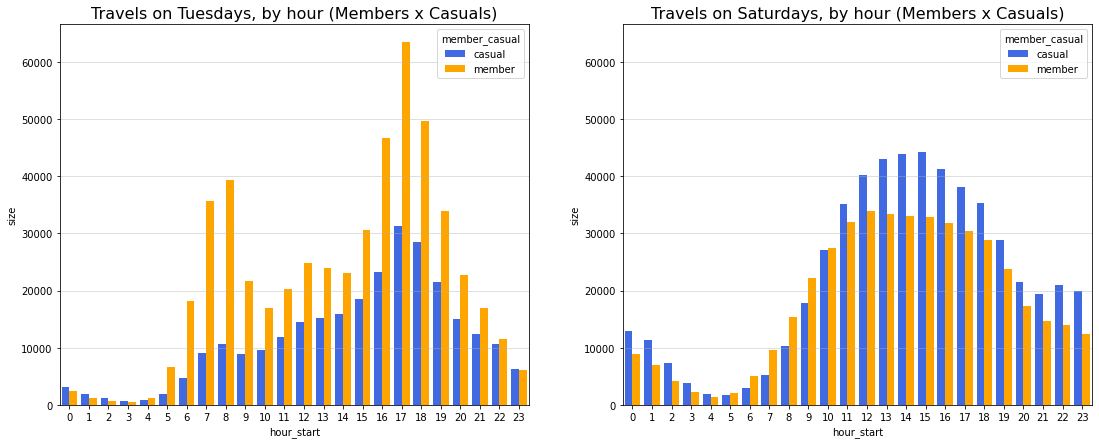

In [26]:
fig, axes = plt.subplots(1,2, sharey=True)
fig.set_size_inches(18.5, 7)
hour_only_tuesday = full_df.loc[full_df['day_of_the_week'] == 'Tuesday']
hour_only_tuesday = hour_only_tuesday.groupby(['hour_start', 'member_casual'], as_index = False).size()
#hour_only_tuesday = hour_only_tuesday.pivot("hour_start", "member_casual", "size")
sns.barplot(ax=axes[0], data=hour_only_tuesday, x="hour_start", y='size', hue="member_casual", palette=['royalblue', 'orange'], saturation=1)

hour_only_saturday = full_df.loc[full_df['day_of_the_week'] == 'Saturday']
hour_only_saturday = hour_only_saturday.groupby(['hour_start', 'member_casual'], as_index = False).size()
#hour_only_saturday = hour_only_saturday.pivot("hour_start", "member_casual", "size")
sns.barplot(ax=axes[1], data=hour_only_saturday, x="hour_start", y='size', hue="member_casual", palette=['royalblue', 'orange'], saturation=1)

axes[1].tick_params(labelleft = True)

axes[0].set_title('Travels on Tuesdays, by hour (Members x Casuals)', size = 16)
axes[1].set_title('Travels on Saturdays, by hour (Members x Casuals)', size = 16)

axes[0].grid(axis='y', alpha=0.5)
axes[1].grid(axis='y', alpha=0.5)


Os resultados são coerentes com as nossas expectativas. Ainda assim, é notável que os Members utilizam bastante o nosso serviço mesmo durante o fim de semana.

Já conseguimos extrair bastantes insights relevantes utilizando apenas o dia e a hora que as viagens acontecem. Em resumo, notamos que durante a semana há dois picos no uso das bicicletas pelos usuários que assinam o plano anual (Members), pico estes que coincidem com os horarios de ir e voltar do trabalho. Já os que usuários Casuals tem um único pico, que ocorre apenas no horário de saída do trabalho. Notamos também que durante o fim de semana o uso das bicicletas é bastante alto, e os usuários casuals superam os usuários Members em quase todos os horários do dia. É digno de nota que o número dessas viagens aos sábados é bastante grande, e se mantém relativamente constante durante toda a tarde. **Converter esses usuários para o plano Member seria muito lucrativo para a empresa, especialmente porque eles utilizam mais as bicicletas nos fins de semana. Usuários que pagam pelo serviço e o utiliza pouco faria com que o custo de manutenção/operação das bicicletas por usuário diminuísse.**

Agora, nosso objetivo será observar os dados relativos aos meses do ano.

C:\Users\Victor\AppData\Local\Temp\ipykernel_9528\798538565.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  groupedbymonth = groupedbymonth.pivot("month_name", "member_casual", "size")


<AxesSubplot: xlabel='month_name'>

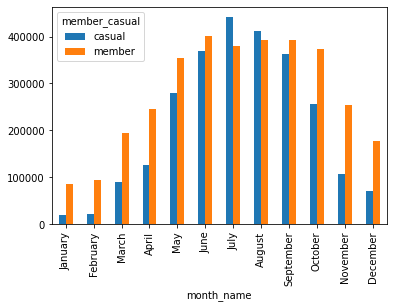

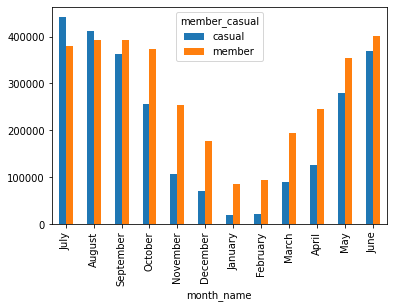

In [27]:
groupedbymonth = full_df.groupby(['month_name', 'member_casual'], as_index = False).size()
groupedbymonth = groupedbymonth.pivot("month_name", "member_casual", "size")
#groupedbymonth = groupedbymonth.reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])
groupedbymonth = groupedbymonth.reindex(['July','August','September','October','November','December','January','February','March','April','May','June'])
groupedbymonth2 = groupedbymonth.reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])
groupedbymonth2.plot(kind='bar')
groupedbymonth.plot(kind='bar')

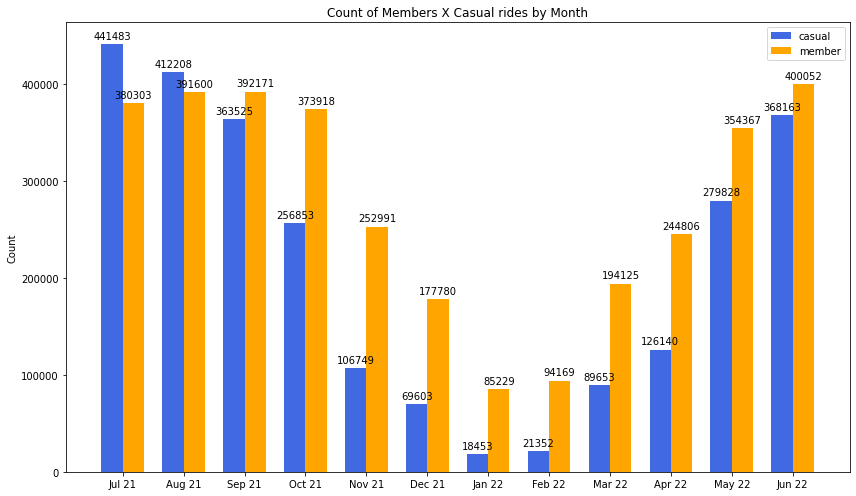

In [28]:
fig2, ax2 = plt.subplots(figsize=(12, 7))
lenmonth = np.arange(len([1,2,3,4,5,6,7,8,9,10,11,12]))
barscasual2 = ax2.bar(lenmonth - width/2, groupedbymonth.casual, 0.35, label='casual', color='royalblue')
barsmember2 = ax2.bar(lenmonth + width/2, groupedbymonth.member, 0.35, label='member', color='orange')

ax2.bar_label(barscasual2, padding=3)
ax2.bar_label(barsmember2, padding=3)

ax2.set_ylabel('Count')
ax2.set_title('Count of Members X Casual rides by Month')
ax2.set_xticks(lenmonth, labels=['Jul 21','Aug 21','Sep 21','Oct 21','Nov 21','Dec 21','Jan 22','Feb 22','Mar 22','Apr 22','May 22','Jun 22'])
ax2.legend()

fig2.tight_layout()

#ax3 = ax2.twinx()
#ax2.plot(complete_df_temp.date, complete_df_temp.avgTemp, markersize=2, markeredgewidth=0, linestyle='-')

plt.show()

O gráfico acima nos mostra uma informação importantíssima: que o número de viagens de ambos os tipos de clientes varia muito durante os meses do ano. Isso faz todo sentido, considerando que o inverno em Chicago é rigoroso, o que impede a maioria das pessoas de andar de bicicleta. Esse gráfico traz também um desafio para o nosso negócio: os Casuals pagam pelo serviço apenas quando fazem uma viagem. Isso quer dizer que durante os meses mais frios esses clientes simplesmente não pagam pelo serviço. Por outro lado, os Members assinam anualmente, ou seja, mesmo nos meses em que não estão utilizando as bicicletas, eles estão pagando a assinatura. Esse fato sustenta a preocupação do gerente de marketing (o arquivo com o problema de negócio, em inglês, está neste mesmo repositório). Esse gráfico é uma excelente sustentação para a hipótese do gerente de marketing.

Repare também que os dados começam em Julho de 2021 e terminam em Junho de 2022. Isso ocorre porque eu peguei os dados mais recentes que haviam disponíveis quando fiz uma versão privada e de teste desse trabalho. Ou seja, os dados cobrem um período de um ano, mas que vão de Julho de 2021 até Junho de 2022.

### Cruzamento com dados públicos.

Quero sustentar minha hipótese de que a variação no uso do serviço de bicicletas tem uma relação direta com a mudança da temperatura em Chicago. Para fazer isso utilizarei uma API pública e gratuita de dados meteorológicos disponibilizada pela National Oceanic and Atmospheric Administration (NOAA), um orgão do governo dos Estados Unidos. O período de tempo é o mesmo período dos nossos dados de viagens de bicicleta: 1 de Julho de 2021 até 30 de Junho de 2022.

Após eu explorar e entender como funciona a API, selecionei a estação meteorológica que me pareceu mais adequada e com os dados mais completos para nossos objetivos.

In [29]:
#O código da estação escolhida é GHCND:USW00094846
#token = json.load('C:/Users/Victor/Desktop/Estudos_Data/GoogleProjetoFinal/weathertoken.json')

with open('C:/Users/Victor/Desktop/Estudos_Data/GoogleProjetoFinal/weathertoken.json') as f:  
      token = json.load(f)
dates_temp = []
temps = []

r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&datatypeid=PRCP&limit=1000&stationid=GHCND:USW00094846&startdate=2021-07-01&enddate=2022-06-30', headers={'token':token['noaa_weather_token']})
d = json.loads(r.text)

In [30]:
avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
dates_temp += [item['date'] for item in avg_temps]
temps += [item['value'] for item in avg_temps]

df_temp = pd.DataFrame()

df_temp['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_temp]
df_temp['avgTemp'] = [float(v)/10.0*1.8 + 32 for v in temps]

Ainda que esta seja a melhor estação, ela ainda apresenta problemas: ela não coletou os dados de temperatura média em janeiro e fevereiro de 2022 (exceto pelo dia 28 de fevereiro de 2022). A forma que encontrei de garantir a integridade dos dados foi adicionando valores "NaN" ao dataframe de origem para aqueles dias em que não há dados. A não resolução desse problema poderia gerar visualizações completamente equivocadas.

In [31]:
months = pd.DataFrame({
    'date': pd.date_range(
        start = pd.Timestamp('2022-01'),                        
        end = pd.Timestamp('2022-02') + pd.offsets.MonthEnd(0),
        freq = 'D'
    )
})

In [32]:
complete_df_temp = pd.concat([df_temp, months]).sort_values(by='date',ascending=True)
complete_df_temp = complete_df_temp.reset_index(drop=True)
complete_df_temp = complete_df_temp.drop(242).reset_index(drop=True)
complete_df_temp

,date,avgTemp
0,2021-07-01,71.24
1,2021-07-02,64.76
2,2021-07-03,70.34
3,2021-07-04,79.16
4,2021-07-05,81.68
...,...,...
360,2022-06-26,75.02
361,2022-06-27,70.34
362,2022-06-28,71.78
363,2022-06-29,76.82


Agora sim nossos dados estão integros. O número de 365 registros é coerente com o nosso propósito (já que estamos analisando o período exato de um um ano). Finalmente podemos gerar gráficos utilizando os dados de temperatura coletados de uma fonte independente. Vamos colocar nossa hipótese à prova e descobrir se existe alguma correlação entre a temperatura e o número de viagens de bicicletas de nossos clientes. Nossa hipotese é de que existe uma correlação positiva.

In [33]:
dfgroupedbydate = full_df.groupby(["full_date"], as_index=False)['ride_id'].count()
dfgroupedbydate['full_date_start'] = pd.to_datetime(dfgroupedbydate['full_date'], format='%Y-%m-%d')

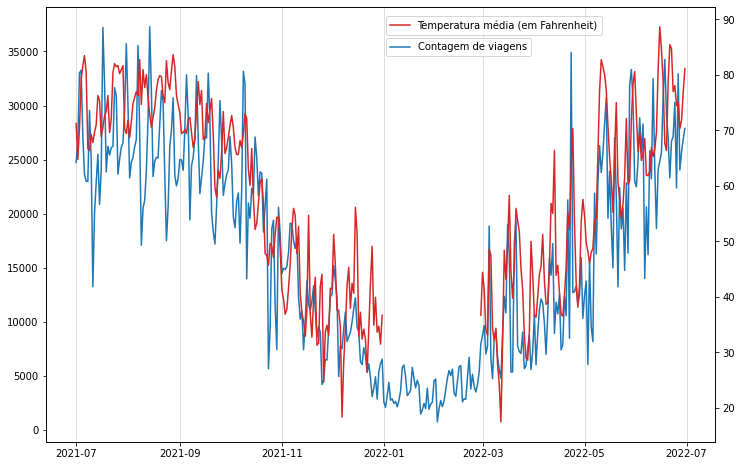

In [34]:
fig3, ax3 = plt.subplots(figsize=(12, 8))
ax4 = ax3.twinx()
ax3.plot(dfgroupedbydate.full_date_start, dfgroupedbydate.ride_id, markersize=2, markeredgewidth=0, linestyle='-', color='tab:blue', label='Contagem de viagens')
ax3.legend(loc=2, bbox_to_anchor=(0.5,0.94))
ax3.grid(alpha=0.5, axis='x')
ax4.plot(complete_df_temp.date, complete_df_temp.avgTemp, markersize=2, markeredgewidth=0, linestyle='-', color='tab:red', label='Temperatura média (em Fahrenheit)')
ax4.legend(loc=2, bbox_to_anchor=(0.5,0.99))
plt.show()

Fantástico! vemos que existe uma correlação positiva: no geral, quando a temperatura da cidade diminuiu, o número de viagens também diminui. O espaço que a linha vermelha se rompe é causado pela falta de dados da estação meteorológica selecionada. Caso esse fosse um projeto numa empresa, poderiamos usar um serviço pago, que provavelmente proveria informações mais completas e bem estruturadas. Ainda assim, nossa hipótese parece fazer sentido.

### Distribuição espacial das estações de bicicleta

Agora, vamos analisar como as viagens são distribuidas no mapa de Chicago. Observaremos a distribuições das estações mais e menos utilizadas. Vamos fazer tudo isso na forma de um mapa, já que temos os dados de latitude e longitude.

In [35]:
start_station_df = full_df.groupby(by='start_station_id', as_index=False).size().sort_values(by='size')
#start_station_df
start_station_df = start_station_df[(start_station_df['size'] > 1)]
df_map_stations = pd.merge(start_station_df,full_df[['start_station_id', 'start_station_name', 'start_lat', 'start_lng']],on='start_station_id', how='left')
df_map_stations = df_map_stations.drop_duplicates(subset='start_station_id').reset_index(drop=True)

In [36]:
df_map_stations.sort_values(by = 'size', ascending=False).head()

,start_station_id,size,start_station_name,start_lat,start_lng
1101,13022,82517,Streeter Dr & Grand Ave,41.892278,-87.612043
1100,LF-005,46864,Lake Shore Dr & North Blvd,41.911714,-87.626766
1099,13042,43607,Michigan Ave & Oak St,41.900960,-87.623777
1098,13300,43495,Lake Shore Dr & Monroe St,41.880958,-87.616743
1097,TA1308000050,43477,Wells St & Concord Ln,41.912133,-87.634656


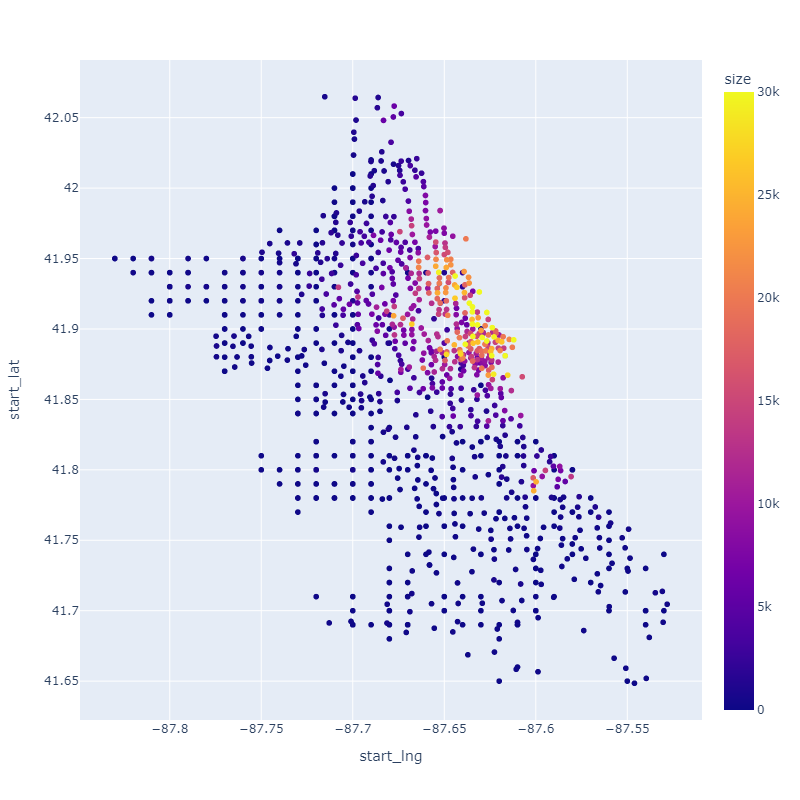

In [37]:
figscatter = px.scatter(df_map_stations, x='start_lng', y='start_lat', hover_name='start_station_name', 
           color = 'size', range_color = [0,30000],
           width=800, height=800)
figscatter.show("png")

A visualização acima nos permite localizar as estações de bicicletas mais utilizadas (usamos o ponto de partida da viagem de bicicleta, mas utilizando a estação de chegada o resultado é o mesmo). Embora esse formato não seja familiar para um brasileiro, os pontos formam quase que perfeitamente o formato da cidade americana de Chicago, ou seja, temos estações espalhadas por toda a cidade. A parte do mapa que mais chama a atenção (que concentra os pontos amarelos) é composta por duas regiões de Chicago, a "Central" e a "North Side". Essas são as duas regiões mais ricas, e também são densamente povoadas.

O gráfico acima mostra a informação que buscamos sem criar uma visualização poluída. Todavia, seria interessante vermos esses mesmos pontos no mapa da cidade de Chicago. Apenas para fins de maior interatividade do usuário com os dados, vou criar este mesmo gráfico sobre o mapa da cidade.

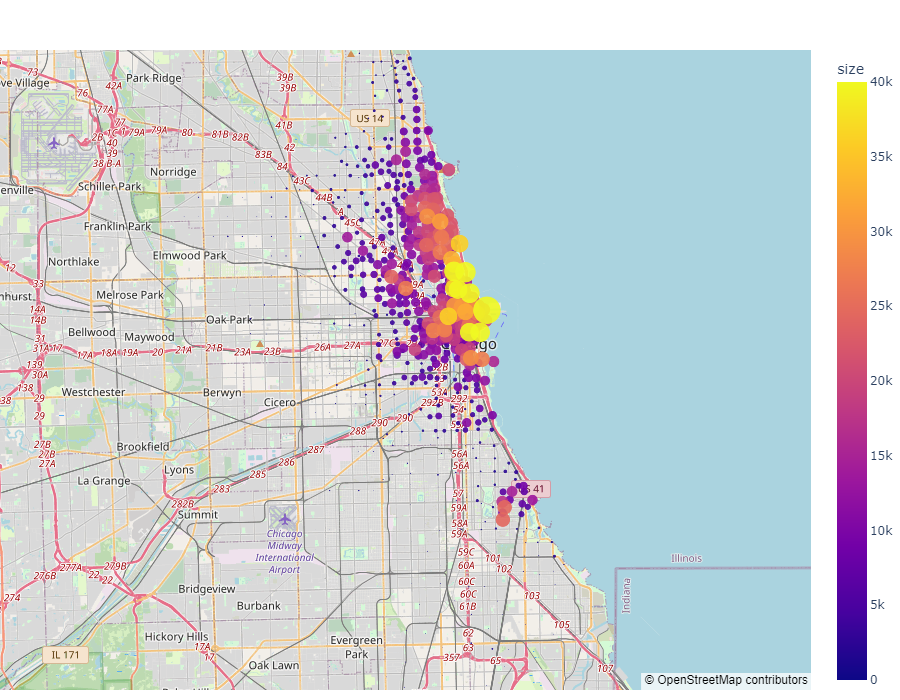

In [38]:
figmap = px.scatter_mapbox(df_map_stations,
                          lon = df_map_stations['start_lng'], lat = df_map_stations['start_lat'],
                          zoom=10, color = df_map_stations['size'], range_color=[0,40000], size = df_map_stations['size'],
                          size_max = 20, opacity = 0.9, width = 900, height = 700)
figmap.update_layout(mapbox_style = "open-street-map")
figmap.update_layout(margin={"r":0,"t":50, "l":0, "b":10})
figmap.show("png")

### Tempo de uso médio das bicicletas, Members x Casuals

Há uma última análise que me parece interessante: quero saber o tempo médio de cada viagem de acordo com o tipo de usuário. É de se supor que uma pessoa não vai percorrer uma longa distância de bicicleta indo para o trabalho. Se o trabalho ficar muito longe do ponto de partida, seria mais logico utilizar transporte público ou carro. Todavia, é de se supor que uma viagem de bicicleta a lazer dure um tempo bem maior. Vamos ver se essas suposições são apoiadas pelos nossos dados.

In [39]:
#estatísticas do dataset completo
full_df['travel_time_in_min'].describe()

count                      5895521
mean     0 days 00:17:53.253612530
std      0 days 00:32:37.785114303
min                0 days 00:00:00
25%                0 days 00:06:16
50%                0 days 00:11:09
75%                0 days 00:20:10
max                0 days 23:59:57
Name: travel_time_in_min, dtype: object

In [40]:
#estatísticas para os usuários Casuals
full_df.query('member_casual == "casual"').describe()['travel_time_in_min']

count                      2554010
mean     0 days 00:24:37.990635118
std      0 days 00:43:25.605415192
min                0 days 00:00:00
25%                0 days 00:08:27
50%                0 days 00:14:49
75%                0 days 00:26:59
max                0 days 23:59:55
Name: travel_time_in_min, dtype: object

In [41]:
#estatísticas para os usuários Members
full_df.query('member_casual == "member"').describe()['travel_time_in_min']

count                      3341511
mean     0 days 00:12:43.901824354
std      0 days 00:19:22.957240771
min                0 days 00:00:00
25%                0 days 00:05:15
50%                0 days 00:09:04
75%                0 days 00:15:43
max                0 days 23:59:57
Name: travel_time_in_min, dtype: object

Vemos que o tempo médio de uma viagem de um Casual é de 24 minutos, o dobro do tempo médio de uma viagem de um Member, que são 12 minutos.

In [42]:
frequent_trips = full_df.groupby(['start_station_name', 'end_station_name', 'member_casual'], as_index=False).agg({'travel_time_in_min': ['mean', 'size']})
frequent_trips.columns = ['start_station_name', 'end_station_name','member_casual', 'average_travel_time', 'size']
frequent_trips = frequent_trips.sort_values(by='size', ascending=False).reset_index(drop=True)
frequent_trips.head(10)

,start_station_name,end_station_name,member_casual,average_travel_time,size
0,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,casual,0 days 00:44:45.248317392,11292
1,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,casual,0 days 00:39:09.824136763,5908
2,Ellis Ave & 60th St,University Ave & 57th St,member,0 days 00:05:15.482165262,5579
3,University Ave & 57th St,Ellis Ave & 60th St,member,0 days 00:04:58.946345111,5349
4,Ellis Ave & 60th St,Ellis Ave & 55th St,member,0 days 00:05:51.659154929,5325
5,Michigan Ave & Oak St,Michigan Ave & Oak St,casual,0 days 00:50:30.418296892,5214
6,DuSable Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,casual,0 days 00:29:25.237681159,4830
7,Ellis Ave & 55th St,Ellis Ave & 60th St,member,0 days 00:05:49.073367260,4716
8,Millennium Park,Millennium Park,casual,0 days 00:43:45.457142857,4690
9,Streeter Dr & Grand Ave,Millennium Park,casual,0 days 00:34:42.863485351,3311


In [43]:
#esse código é só para conferir se a conta está correta. 
#Perdemos aprox 900 k registros porque as linhas com nome de estação vazias foram eliminadas quando fizemos o groupby.

frequent_trips['size'].sum()

4678094

A tabela acima contem diversas informações relevantes. As viagens então agrupadas por estação de saída, estação de chegada e tipo de usuário, e esses são os 10 registros com o maior número de viagens. Primeiro, podemos notar que quando o member_casual é igual a "casual", o tempo médio da viagem é muito maior do que quando o registro é do tipo "member". Isso fortalece a hipótese de que os casuals utilizam as bicicletas como lazer, e não como transporte. 

Reparemos em mais um detalhe: os dois registros com maior numero de viagens tem o início e o fim na mesma estação, e um tempo médio de viagem longo, ou seja, os usuários pegam as bicicletas, passeiam por aproximadamente 45 minutos e voltam ao ponto de origem. Reparemos também que quando o registro é o tipo member, nenhum dos top 10 percursos tem a estação de origem igual a de saída. 

Há mais um ponto a se observar: repare no registro de índice 6. Seu início ocorre em 'DuSable Lake Shore Dr & Monroe St' e termina em 'Streeter Dr & Grand Ave'. Esse percurso tem uma ciclovia que passa por um belo parque na orla de Chicago, e pode ser feito em apenas 7 minutos, de acordo com o Google Maps. Todavia, em média os usuários demoraram 29 minutos do momento que tiraram até o momento que devolveram a bicicleta, ou seja, eles estavam passeando, e não preocupados em chegar ao destino o mais rápido possível.

In [44]:
same_place = frequent_trips.where(frequent_trips.start_station_name == frequent_trips.end_station_name)
same_place = same_place.dropna()
same_place.head()

,start_station_name,end_station_name,member_casual,average_travel_time,size
0,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,casual,0 days 00:44:45.248317392,11292.0
1,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,casual,0 days 00:39:09.824136763,5908.0
5,Michigan Ave & Oak St,Michigan Ave & Oak St,casual,0 days 00:50:30.418296892,5214.0
8,Millennium Park,Millennium Park,casual,0 days 00:43:45.457142857,4690.0
11,Montrose Harbor,Montrose Harbor,casual,0 days 00:56:00.500683994,2924.0


In [45]:
other_place = frequent_trips.where(frequent_trips.start_station_name != frequent_trips.end_station_name)
other_place = other_place.dropna()
other_place.head()

,start_station_name,end_station_name,member_casual,average_travel_time,size
2,Ellis Ave & 60th St,University Ave & 57th St,member,0 days 00:05:15.482165262,5579.0
3,University Ave & 57th St,Ellis Ave & 60th St,member,0 days 00:04:58.946345111,5349.0
4,Ellis Ave & 60th St,Ellis Ave & 55th St,member,0 days 00:05:51.659154929,5325.0
6,DuSable Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,casual,0 days 00:29:25.237681159,4830.0
7,Ellis Ave & 55th St,Ellis Ave & 60th St,member,0 days 00:05:49.073367260,4716.0
